# MinMod Knowledge Graph

### live at [https://minmod.isi.edu/](https://minmod.isi.edu/) wrapping a [SPARQL Endpoint](https://minmod.isi.edu/sparql).

MinMod is the mineral data **Knowledge Graph (KG)**, integrating heterogeneous data sources including: grade-tonnage data extracted from **mine reports**, **scholarly articles**, **mine site databases**, and **structured tables** to provide a rich, queryable graph of mineral site information, and **links** to additional knowledge bases such as [GeoKB](https://geokb.wikibase.cloud/).

### data in this knowledge graph adhere to this [schema](https://github.com/DARPA-CRITICALMAAS/schemas/blob/main/ta2/README.md).

## Why KGs?

<img src="demo_imgs/minmod_kg.png" alt="minmod kg" width="250"/>

- KGs
  - graphs are natural way to **encode data**
  - KGs use **semantic concepts & relationships** to create a **Semantic Network**
  - involves **spatial & temporal** information
- RDF
  - framework within the **Semantic Web** stack
  - an extension of WWW, enabling the Web of Data (aka **"Linked Data"**)
  - Linked Open Data & **FAIR** data principles

## Constructing the KG

- Extracted data --> `JSON-LD` readers / `TTL` triples reader
- Predefined data
  - Open set of commodity entities (based on MRDS/GeoKB)
  - Finite set of deposit type entities
  - Ontology following schema to enforce class & property constraints

<img src="demo_imgs/minmod_pipeline.png" alt="minmod kg" width="600"/>

## Interacting with the KG
MinMod KG `SPARQL` Sandbox

In [ ]:
import re
import json
import requests
import textdistance
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geopandas as gpd
import contextily as ctx
from tqdm import tqdm
from collections import Counter
from shapely import wkt
from shapely.wkt import loads
from shapely.errors import WKTReadingError
import warnings

warnings.filterwarnings("ignore")
tqdm.pandas()

In [2]:
def safe_wkt_load(wkt_string):
    try:
        return loads(wkt_string)
    except WKTReadingError as e:
        print(f"Error converting WKT: {e}")
        return None

In [3]:
def run_sparql_query(query, endpoint='https://minmod.isi.edu/sparql', values=False):
    # add prefixes
    final_query = '''
    PREFIX dcterms: <http://purl.org/dc/terms/>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX : <https://minmod.isi.edu/resource/>
    PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
    PREFIX owl: <http://www.w3.org/2002/07/owl#>
    PREFIX gkbi: <https://geokb.wikibase.cloud/entity/>
    PREFIX gkbt: <https://geokb.wikibase.cloud/prop/direct/>
    PREFIX geo: <http://www.opengis.net/ont/geosparql#>
    \n''' + query
    # send query
    response = requests.post(
        url=endpoint,
        data={'query': final_query},
        headers={
            "Content-Type": "application/x-www-form-urlencoded",
            "Accept": "application/sparql-results+json"  # Requesting JSON format
        },
        verify=False  # Set to False to bypass SSL verification as per the '-k' in curl
    )
    #print(response.text)
    try:
        qres = response.json()
        if "results" in qres and "bindings" in qres["results"]:
            df = pd.json_normalize(qres['results']['bindings'])
            if values:
                filtered_columns = df.filter(like='.value').columns
                df = df[filtered_columns]
            return df
    except:
        return None

In [4]:
def run_minmod_query(query, values=False):
    return run_sparql_query(query, endpoint='https://minmod.isi.edu/sparql', values=values)

def run_geokb_query(query, values=False):
    return run_sparql_query(query, endpoint='https://geokb.wikibase.cloud/query/sparql', values=values)

--------------------------------------------------------

In [5]:
pd.set_option('display.max_rows', 20)

### 0. General stats

total number of triples in KG (sanity test) = number of edges (predicates in triples)

In [6]:
query = ''' SELECT (COUNT(?p) as ?count)
            WHERE {
                ?s ?p ?o .
            } '''
run_minmod_query(query)

,count.type,count.datatype,count.value
0,literal,http://www.w3.org/2001/XMLSchema#integer,1880589


number of classes

In [7]:
query = ''' SELECT (COUNT(DISTINCT ?class) AS ?count)
            WHERE {
                ?class a rdfs:Class .
                FILTER(!isBlank(?class))  # exclude blank nodes
            } '''
run_minmod_query(query)

,count.type,count.datatype,count.value
0,literal,http://www.w3.org/2001/XMLSchema#integer,16


show them

In [8]:
query = ''' SELECT ?class
            WHERE {
                ?class a rdfs:Class .
                FILTER(!isBlank(?class))
            } '''
run_minmod_query(query)

,class.type,class.value
0,uri,https://minmod.isi.edu/resource/MineralInventory
1,uri,https://minmod.isi.edu/resource/MineralSite
2,uri,https://minmod.isi.edu/resource/Unit
3,uri,https://minmod.isi.edu/resource/Reference
4,uri,https://minmod.isi.edu/resource/Grade
5,uri,https://minmod.isi.edu/resource/DepositType
6,uri,https://minmod.isi.edu/resource/Document
7,uri,https://minmod.isi.edu/resource/MappableCriteria
8,uri,https://minmod.isi.edu/resource/ResourceReserv...
9,uri,https://minmod.isi.edu/resource/GeologyInfo


number of instances (subjects with a specific type, excluding literals and blank nodes)

In [9]:
query = ''' SELECT (COUNT(DISTINCT ?instance) AS ?count)
            WHERE {
                ?instance a ?type .
                FILTER(!isBlank(?instance))
                FILTER(!isLiteral(?instance))
            } '''
run_minmod_query(query)

,count.type,count.datatype,count.value
0,literal,http://www.w3.org/2001/XMLSchema#integer,207155


number of blank nodes (subjects or objects that are not URIs or literals)

In [10]:
query = ''' SELECT (COUNT(?s) AS ?countSubjects) (COUNT(?o) AS ?countObjects)
            WHERE {
                { ?s ?p ?o FILTER(isBlank(?s)) }
                UNION
                { ?s ?p ?o FILTER(isBlank(?o)) }
            } '''
run_minmod_query(query)

,countSubjects.type,countSubjects.datatype,countSubjects.value,countObjects.type,countObjects.datatype,countObjects.value
0,literal,http://www.w3.org/2001/XMLSchema#integer,1004664,literal,http://www.w3.org/2001/XMLSchema#integer,1004664


### 1. Deposit Types

In [11]:
query = '''
SELECT ?dep ?dname ?dgroup ?denv
WHERE {
    ?dep a              :DepositType .
    ?dep rdfs:label     ?dname .
    ?dep :deposit_group ?dgroup .
    ?dep :environment   ?denv .
} '''
run_minmod_query(query, values=True)

,dep.value,dname.value,dgroup.value,denv.value
0,https://minmod.isi.edu/resource/Q366,Sedimentary manganese,Manganese,Basin chemical
1,https://minmod.isi.edu/resource/Q362,Superior-type banded iron formation,Iron formation,Basin chemical
2,https://minmod.isi.edu/resource/Q400,Iron sulfide polymetallic,Metasomatic iron,Regional metasomatic
3,https://minmod.isi.edu/resource/Q457,Climax-type porphyry molybdenum,Porphyry,Magmatic hydrothermal
4,https://minmod.isi.edu/resource/Q345,Lacustrine evaporite trona,Evaporite,Basin evaporative
...,...,...,...,...
184,https://minmod.isi.edu/resource/Q343,Marine evaporite potash,Evaporite,Basin evaporative
185,https://minmod.isi.edu/resource/Q301,Residual placer tin,Placer,Erosional
186,https://minmod.isi.edu/resource/Q330,Supergene zinc,Supergene,Supergene
187,https://minmod.isi.edu/resource/Q379,Kipushi-type sediment- hosted copper- zinc-lead,Sediment-hosted,Basin hydrothermal


search by string in all three vars (cols):

In [12]:
DEPOSIT_QUERY_TEMPLATE_ANY = '''
SELECT ?dep ?dname ?dgroup ?denv
WHERE {
    ?dep a              :DepositType .
    ?dep rdfs:label     ?dname .
    ?dep :deposit_group ?dgroup .
    ?dep :environment   ?denv .
    FILTER(
        CONTAINS(LCASE(?dname),  "%s") ||
        CONTAINS(LCASE(?dgroup), "%s") ||
        CONTAINS(LCASE(?denv),   "%s")
    )
} '''

In [13]:
search_string = 'mafic'

In [14]:
query = DEPOSIT_QUERY_TEMPLATE_ANY % ((search_string.lower(),) * 3)
run_minmod_query(query, values=True)

,dep.value,dname.value,dgroup.value,denv.value
0,https://minmod.isi.edu/resource/Q489,Impact U-M intrusion nickel- copper-PGE,Ultramafic and (or) mafic intrusion,Magmatic
1,https://minmod.isi.edu/resource/Q480,U-M layered intrusion iron-titanium- vanadium,Ultramafic and (or) mafic-layered intrusion,Magmatic
2,https://minmod.isi.edu/resource/Q409,Mafic-ultramafic VMS,Volcanogenic massive sulfide (VMS),Volcanic basin hydrothermal
3,https://minmod.isi.edu/resource/Q376,Siliciclastic-mafic barite,Sediment-hosted,Basin hydrothermal
4,https://minmod.isi.edu/resource/Q477,U-M layered intrusion chromium,Ultramafic and (or) mafic-layered intrusion,Magmatic
5,https://minmod.isi.edu/resource/Q485,Arc U-M intrusion titanium- vanadium,Ultramafic and (or) mafic intrusion,Magmatic
6,https://minmod.isi.edu/resource/Q478,U-M layered intrusion nickel- copper-PGE,Ultramafic and (or) mafic-layered intrusion,Magmatic
7,https://minmod.isi.edu/resource/Q481,U-M intrusion nickel-copper- PGE,Ultramafic and (or) mafic intrusion,Magmatic
8,https://minmod.isi.edu/resource/Q486,Arc U-M intru- sion nickel- copper-PGE,Ultramafic and (or) mafic intrusion,Magmatic
9,https://minmod.isi.edu/resource/Q411,Bimodal-mafic VMS,Volcanogenic massive sulfide (VMS),Volcanic basin hydrothermal


### 2. Mineral Inventories

#### 2.1. Statistics

In [15]:
query = ''' SELECT ?commodity (COUNT(?o_inv) AS ?count)
            WHERE {
                ?s :mineral_inventory ?o_inv .
                ?o_inv :category ?cat .
                ?o_inv :commodity [ :name ?commodity ] .
                ?o_inv :ore [ :ore_value ?ore ] .
                ?o_inv :grade [ :grade_value ?grade ] .
            }
            GROUP BY ?commodity '''
run_minmod_query(query, values=True)

,commodity.value,count.value
0,Nickel,1562
1,Zinc,1078


#### 2.2. **Zinc** Ore values, from all inventories, & their grades, for inventories with grade >= 5

In [16]:
query = ''' SELECT ?o_inv ?comm_name ?ore ?grade ?cutoff_grade ?cat
            WHERE {
                ?s :mineral_inventory ?o_inv .
                ?o_inv :category ?cat .
                ?o_inv :commodity [ :name "Zinc"@en ] .
                
                ?o_inv :ore [ :ore_value ?ore ] .
                ?o_inv :grade [ :grade_value ?grade ] .
                FILTER (?grade >= 5)
            } '''
run_minmod_query(query, values=True)

,o_inv.value,ore.value,grade.value,cat.value
0,https://minmod.isi.edu/resource/invn__Q589__c_...,6.6,6.4,https://minmod.isi.edu/resource/INDICATED
1,https://minmod.isi.edu/resource/invn__Q589__c_...,6.6,6.4,https://minmod.isi.edu/resource/MEASURED
2,https://minmod.isi.edu/resource/invn__Q589__c_...,0.83,5.0,https://minmod.isi.edu/resource/INDICATED
3,https://minmod.isi.edu/resource/invn__Q589__c_...,0.83,5.0,https://minmod.isi.edu/resource/MEASURED
4,https://minmod.isi.edu/resource/invn__Q589__c_...,135.06,6.12,https://minmod.isi.edu/resource/INDICATED
...,...,...,...,...
283,https://minmod.isi.edu/resource/invn__Q589__c_...,18.27,6.62,https://minmod.isi.edu/resource/MEASURED
284,https://minmod.isi.edu/resource/invn__Q589__c_...,6.15,12.14,https://minmod.isi.edu/resource/INDICATED
285,https://minmod.isi.edu/resource/invn__Q589__c_...,6.15,12.14,https://minmod.isi.edu/resource/MEASURED
286,https://minmod.isi.edu/resource/invn__Q589__c_...,0.91,6.06,https://minmod.isi.edu/resource/INDICATED


#### 2.3. **Nickel** Ore values, from all inventories, their grades & cutoff grades

In [17]:
query = ''' SELECT ?o_inv ?ore ?grade ?cutoff_grade ?cat
            WHERE {
                ?s :mineral_inventory ?o_inv .
                ?o_inv :category ?cat .
                ?o_inv :commodity [ :name "Nickel"@en ] .
                ?o_inv :ore [ :ore_value ?ore ] .
                ?o_inv :grade [ :grade_value ?grade ] .
                ?o_inv :cutoff_grade [ :grade_value ?cutoff_grade ] .
            } '''
run_minmod_query(query, values=True)

,o_inv.value,ore.value,grade.value,cutoff_grade.value,cat.value
0,https://minmod.isi.edu/resource/httpsw3idorgus...,3639000,1.83,0.83,https://minmod.isi.edu/resource/indicated
1,https://minmod.isi.edu/resource/httpsw3idorgus...,158651000,0.207,0.6,https://minmod.isi.edu/resource/inferred
2,https://minmod.isi.edu/resource/httpsw3idorgus...,158651000,0.207,0.8,https://minmod.isi.edu/resource/inferred
3,https://minmod.isi.edu/resource/httpsw3idorgus...,158651000,0.207,1,https://minmod.isi.edu/resource/inferred
4,https://minmod.isi.edu/resource/httpsw3idorgus...,158651000,0.207,0.7,https://minmod.isi.edu/resource/inferred
...,...,...,...,...,...
2260,https://minmod.isi.edu/resource/httpsw3idorgus...,2652000,0.86,0.5,https://minmod.isi.edu/resource/inferred
2261,https://minmod.isi.edu/resource/httpsw3idorgus...,2652000,0.86,0.5,https://minmod.isi.edu/resource/inferred
2262,https://minmod.isi.edu/resource/httpsw3idorgus...,2652000,0.86,0.5,https://minmod.isi.edu/resource/inferred
2263,https://minmod.isi.edu/resource/httpsw3idorgus...,2652000,0.86,0.5,https://minmod.isi.edu/resource/inferred


#### 2.4. All **Nickel** inventories

In [18]:
query = ''' SELECT ?ore ?grade ?cat
            WHERE {
                ?s :mineral_inventory ?o_inv .
                ?o_inv :category ?cat .
                ?o_inv :commodity/:name "Nickel"@en .
                ?o_inv :ore/:ore_value ?ore .
                ?o_inv :grade/:grade_value ?grade .
            } '''
df = run_minmod_query(query, values=True)
df

,ore.value,grade.value,cat.value
0,350000,0.62,https://minmod.isi.edu/resource/probable
1,4.625,0.29,https://minmod.isi.edu/resource/Indicated
2,684.0,1.3,https://minmod.isi.edu/resource/Inferred
3,1.0,0.3,https://minmod.isi.edu/resource/Inferred
4,17.2,0.56,https://minmod.isi.edu/resource/Indicated
...,...,...,...
1557,33.3,0.81,https://minmod.isi.edu/resource/Inferred
1558,11.7,0.02,https://minmod.isi.edu/resource/Measured
1559,48.95,0.08,https://minmod.isi.edu/resource/Inferred
1560,5.643,1.5,https://minmod.isi.edu/resource/Indicated


### 3. Commodities

#### 3.1. all commodities and their `GeoKB` URIs

In [ ]:
# query = ''' SELECT ?ci ?cn ?gi
#             WHERE {
#                 ?ci a :Commodity .
#                 ?ci :name ?cn .
#                 ?ci owl:sameAs ?gi .
#             } '''
# example_df = run_minmod_query(query)
# example_df

#### 3.2. get commodity symboles from `GeoKB`

In [ ]:
# def get_symbol_via_sparql(geokb_uri):
#     query = '''
#     SELECT ?symb
#     WHERE {
#         <%s> gkbt:P17 ?symb .
#     }''' % (geokb_uri)
#     result_record = run_geokb_query(query)
#     if len(result_record) > 0:
#         return result_record.iloc[0]['symb.value']
#     return ""

In [ ]:
# pd.set_option('display.max_rows', 500)

# example_df['geoKB Symbol'] = example_df['gi.value'].progress_apply(get_symbol_via_sparql)
# example_df

### 4. Mineral Sites

#### 4.1. Nickel `MineralSite` instances

In [22]:
query = ''' SELECT ?ms ?msr ?mss ?loc_wkt
            WHERE {
                ?ms a :MineralSite .
                ?ms :record_id ?msr .
                ?ms :source_id ?mss .
                ?ms :location_info [ :location ?loc_wkt ] .
                
                ?ms :mineral_inventory ?mi .
                ?mi :commodity [ :name "Nickel"@en ] .
            } '''
df_2 = run_minmod_query(query, values=True)
df_2

,ms.value,msr.value,mss.value,loc_wkt.value
0,https://minmod.isi.edu/resource/httpsw3idorgus...,1,https://w3id.org/usgs/z/4530692/4J6VP5M9,POINT(25.05 63.85)
1,https://minmod.isi.edu/resource/site__spruce-r...,Spruce Road,Mudd-and-Jowitt-2022-Nickel/AR 2018,POINT (-91.7 47.83)
2,https://minmod.isi.edu/resource/site__sudbury-...,Sudbury-Victoria (KGHM),Mudd-and-Jowitt-2022-Nickel/KGHM Presentation ...,POINT (-81.38751 46.42380)
3,https://minmod.isi.edu/resource/site__sudbury-...,Sudbury Group (Vale),Mudd-and-Jowitt-2022-Nickel/Form 20F 2018,POINT (-81.06776 46.49230)
4,https://minmod.isi.edu/resource/site__sudbury-...,Sudbury-Parkin Offset,Mudd-and-Jowitt-2022-Nickel/AIF 2018,POINT (-80.87806 46.80500)
...,...,...,...,...
101,https://minmod.isi.edu/resource/site__northmet...,NorthMet (Dunka Road),Mudd-and-Jowitt-2022-Nickel/AIF 2018,POINT (-92 47.6)
102,https://minmod.isi.edu/resource/httpsw3idorgus...,1,https://w3id.org/usgs/z/4530692/DSS9VBEK,MULTIPOINT(-92.7 46.7)
103,https://minmod.isi.edu/resource/site__sudbury-...,Sudbury-West Graham,Mudd-and-Jowitt-2022-Nickel/Tech Rep (2018-01),POINT (-81.31286 46.41797)
104,https://minmod.isi.edu/resource/httpsw3idorgus...,1,https://w3id.org/usgs/z/4530692/2P29BJHV,POINT(28.17472 65.94611)


visualize:

100%|████████████████████████████████████████████████████████████████████████████████████| 106/106 [00:00<00:00, 54080.55it/s]


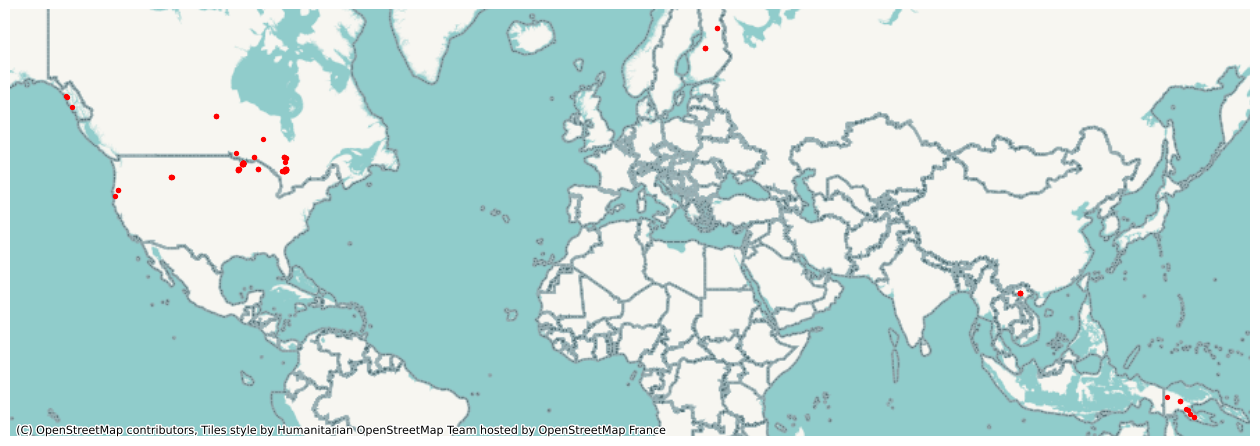

In [23]:
df_2['loc_wkt'] = df_2['loc_wkt.value'].progress_apply(safe_wkt_load)

sample_gdf = gpd.GeoDataFrame(df_2, geometry='loc_wkt', crs='epsg:4326')
# WGS84 (EPSG:4326) to Web Mercator (EPSG:3857).
sample_gdf = sample_gdf.to_crs(epsg=3857)
fig, ax = plt.subplots(figsize=(16, 16))
sample_gdf.plot(ax=ax, color='red', markersize=8)
ax.set_axis_off()
ctx.add_basemap(ax)
plt.show()

## Deposit Type Classification

### Retrieve all deposit classifications

In [24]:
query = '''
SELECT ?ms ?dt_conf ?dt_s ?dt_on ?cn ?cg ?ce ?country
WHERE {
  ?ms a :MineralSite .

  ?ms :location_info [ :country ?country ] .
  
  #?ms :location_info [ :location ?loc ] .
  #FILTER(datatype(?loc) = geo:wktLiteral)
  #?ms :mineral_inventory ?mi .
  #?mi :commodity [ :name "Nickel"@en ] .
  
  ?ms :deposit_type_candidate ?dpc .
  
  ?dpc :confidence ?dt_conf .
  ?dpc :observed_name ?dt_on .
  ?dpc :source ?dt_s .
  
  OPTIONAL { ?dpc :normalized_uri [
      rdfs:label ?cn;
      :deposit_group ?cg;
      :environment ?ce ] }
}
'''
tmp_df = run_minmod_query(query, values=True)

In [25]:
nickel_dc_data_df = pd.DataFrame([
    {
        'url': row['ms.value'], # navigable
        'confidence': row['dt_conf.value'],
        'source': row['dt_s.value'],
        'observed_deposit_name': row['dt_on.value'],
        'deposit_name': row['cn.value'],
        'deposit_group': row['cg.value'],
        'deposit_environment': row['ce.value'],
        'country': row['country.value']
    }
    for index, row in tmp_df.iterrows()
])
nickel_dc_data_df

,url,confidence,source,observed_deposit_name,deposit_name,deposit_group,deposit_environment,country
0,https://minmod.isi.edu/resource/mrds10085464ab...,0.020647859200835228,"algorithm predictions, SRI deposit type classi...",Mafic-ultramafic VMS,Mafic-ultramafic VMS,Volcanogenic massive sulfide (VMS),Volcanic basin hydrothermal,United States
1,https://minmod.isi.edu/resource/mrds10085464ab...,0.033953700214624405,"algorithm predictions, SRI deposit type classi...",U-M layered intrusion chromium,U-M layered intrusion chromium,Ultramafic and (or) mafic-layered intrusion,Magmatic,United States
2,https://minmod.isi.edu/resource/mrds10085464ab...,0.05794547870755195,"algorithm predictions, SRI deposit type classi...",Laterite nickel,Laterite nickel,Laterite,Supergene,United States
3,https://minmod.isi.edu/resource/mrds10085464ab...,0.029323924332857132,"algorithm predictions, SRI deposit type classi...",Ophiolite chromium,Ophiolite chromium,Ophiolite,Magmatic,United States
4,https://minmod.isi.edu/resource/mrds10085464ab...,0.015711316838860512,"algorithm predictions, SRI deposit type classi...",Ophiolite nickel-copper-PGE,Ophiolite nickel-copper-PGE,Ophiolite,Magmatic,United States
...,...,...,...,...,...,...,...,...
15896,https://minmod.isi.edu/resource/mrds1013338690...,0.023143405094742775,"algorithm predictions, SRI deposit type classi...",Ophiolite nickel-copper-PGE,Ophiolite nickel-copper-PGE,Ophiolite,Magmatic,Canada
15897,https://minmod.isi.edu/resource/mrds1013338690...,0.03258713707327843,"algorithm predictions, SRI deposit type classi...",U-M conduit nickel-copper- PGE,U-M conduit nickel-copper- PGE,Ultramafic and (or) mafic conduit,Magmatic,Canada
15898,https://minmod.isi.edu/resource/mrds1013338690...,0.03157040849328041,"algorithm predictions, SRI deposit type classi...",Arc U-M intru- sion nickel- copper-PGE,Arc U-M intru- sion nickel- copper-PGE,Ultramafic and (or) mafic intrusion,Magmatic,Canada
15899,https://minmod.isi.edu/resource/mrds1013338690...,0.026169832795858383,"algorithm predictions, SRI deposit type classi...",U-M intrusion nickel-copper- PGE,U-M intrusion nickel-copper- PGE,Ultramafic and (or) mafic intrusion,Magmatic,Canada


In [26]:
nickel_dc_data_df['source'].value_counts()

source
algorithm predictions, SRI deposit type classification, v0b, 20240213    14150
sand                                                                      1686
report                                                                      58
SME                                                                          7
Name: count, dtype: int64

In [27]:
nickel_dc_data_df['country'].value_counts()

country
United States    7304
Canada           2125
Australia        1351
Russia            712
South Africa      536
                 ... 
Cameroon            4
Côte d'Ivoire       4
Togo                3
Oman                3
Guinea              3
Name: count, Length: 92, dtype: int64

In [28]:
nickel_dc_data_df[nickel_dc_data_df['country'].str.contains("United")]['country'].value_counts()

country
United States               7304
United Kingdom                25
United States of America       6
Name: count, dtype: int64

In [29]:
# uncomment to export to csv: 
#nickel_dc_data_df.to_csv('nickel_dc_data_df.csv')

### Consolidating Desposit Type Classification data

In [30]:
'''
Komatiite nickel-copper-PGE                 Q476
U-M layered intrusion nickel- copper-PGE    Q478
U-M intrusion nickel-copper- PGE            Q481
U-M conduit nickel-copper- PGE              Q482
Ophiolite nickel-copper-PGE                 Q484
Arc U-M intru- sion nickel- copper-PGE      Q486
Anorthosite conduit nickel- copper-PGE      Q488
Impact U-M intrusion nickel- copper-PGE     Q489
'''
valid_deposit_Qs = ["Q476", "Q478", "Q481", "Q482", "Q484", "Q486", "Q488", "Q489"]
valid_deposit_Qs = ['https://minmod.isi.edu/resource/' + x for x in valid_deposit_Qs]

In [31]:
query = '''
SELECT ?ms ?oms ?dt_conf ?dt_s ?cn ?cg ?ce ?country ?dtnorm ?dtnorm_label ?loc_wkt
WHERE {
  ?ms a :MineralSite .
  
  ?ms :deposit_type_candidate ?dpc .
  
  ?dpc :confidence ?dt_conf .
  #?dpc :observed_name ?dt_on .
  ?dpc :source ?dt_s .
  OPTIONAL { ?ms owl:sameAs ?oms . }
  ?dpc :normalized_uri ?dtnorm .

  ?dtnorm rdfs:label ?dtnorm_label .
      
  #?ms :mineral_inventory ?mi .
  #?mi :commodity [ :name "Nickel"@en ] .
  
  OPTIONAL {
      ?ms :location_info [ :country ?country ] .
      ?ms :location_info [ :location ?loc_wkt ] .
      FILTER(datatype(?loc_wkt) = geo:wktLiteral)
  }
}'''  

tmp_df = run_minmod_query(query, values=True)

In [32]:
# US data
filtered_us = tmp_df[tmp_df['country.value'].isin(["USA", "United States", "United States of America"])]
filtered_nickel_us = filtered_us[filtered_us['dtnorm.value'].isin(valid_deposit_Qs)]

#### integrate reconciliation `sameAs` data (this will become redundant as we will publish `HyperMineralSite` instances)

In [33]:
'''
# todo: this will be fixed (hyper sites will be queried directly from the KG), but for now this file can be downloaded from:
https://github.com/DARPA-CRITICALMAAS/ta2-minmod-data/tree/main/sandbox/data/
'''
df_er_results = pd.read_csv('data/grouping_result.csv')
df_er_results.dropna(inplace=True)
df_er_results = df_er_results.drop_duplicates(subset=['source', 'source_id'])
query = ''' SELECT ?ms ?ms_record_id ?ms_source_id
            WHERE {
                ?ms a :MineralSite .
                ?ms :record_id ?ms_record_id .
                ?ms :source_id ?ms_source_id .
            } '''
df_all_sites = run_minmod_query(query, values=True)
df_all_sites.dropna(inplace=True)
df_all_sites = df_all_sites.drop_duplicates(subset=['ms_source_id.value', 'ms_record_id.value'])

In [34]:
merged_df = df_er_results.merge(df_all_sites, how='left',
                     left_on=['source', 'source_id'], 
                     right_on=['ms_source_id.value', 'ms_record_id.value'])

In [35]:
hypersite_df = filtered_nickel_us.merge(merged_df, how='left',
                     left_on='ms.value', right_on='ms.value')
hypersite_df['prediction'].fillna(value=-1, inplace=True)
hypersite_df['site_hyper_id'] = hypersite_df.progress_apply(
    lambda x: 'https://minmod.isi.edu/resource/' + str(int(x.prediction)), axis=1)
hypersite_df

100%|█████████████████████████████████████████████████████████████████████████████████| 2505/2505 [00:00<00:00, 139252.38it/s]


,ms.value,dt_conf.value,dt_s.value,dtnorm.value,dtnorm_label.value,country.value,loc_wkt.value,oms.value,Unnamed: 0,source,source_id,prediction,ms_record_id.value,ms_source_id.value,site_hyper_id
0,https://minmod.isi.edu/resource/mrds10085464ab...,0.015711316838860512,"algorithm predictions, SRI deposit type classi...",https://minmod.isi.edu/resource/Q484,Ophiolite nickel-copper-PGE,United States,POINT (-67.01837 18.14928),NaN,1193.0,MRDS,10085464,28.0,10085464,MRDS,https://minmod.isi.edu/resource/28
1,https://minmod.isi.edu/resource/mrds10127384d8...,0.020880183205008507,"algorithm predictions, SRI deposit type classi...",https://minmod.isi.edu/resource/Q486,Arc U-M intru- sion nickel- copper-PGE,United States,POINT (-117.92273 44.57736),NaN,1525.0,MRDS,10127384,333.0,10127384,MRDS,https://minmod.isi.edu/resource/333
2,https://minmod.isi.edu/resource/mrds10127384d8...,0.02021538093686104,"algorithm predictions, SRI deposit type classi...",https://minmod.isi.edu/resource/Q484,Ophiolite nickel-copper-PGE,United States,POINT (-117.92273 44.57736),NaN,1525.0,MRDS,10127384,333.0,10127384,MRDS,https://minmod.isi.edu/resource/333
3,https://minmod.isi.edu/resource/mrds10127384d8...,0.01643197238445282,"algorithm predictions, SRI deposit type classi...",https://minmod.isi.edu/resource/Q482,U-M conduit nickel-copper- PGE,United States,POINT (-117.92273 44.57736),NaN,1525.0,MRDS,10127384,333.0,10127384,MRDS,https://minmod.isi.edu/resource/333
4,https://minmod.isi.edu/resource/mrds1022534048...,0.013713276013731956,"algorithm predictions, SRI deposit type classi...",https://minmod.isi.edu/resource/Q476,Komatiite nickel-copper-PGE,United States,POINT (-123.85506 42.14702),NaN,2094.0,MRDS,10225340,310.0,10225340,MRDS,https://minmod.isi.edu/resource/310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2500,https://minmod.isi.edu/resource/mrds101653019c...,0.013455736450850964,"algorithm predictions, SRI deposit type classi...",https://minmod.isi.edu/resource/Q481,U-M intrusion nickel-copper- PGE,United States,POINT (-122.71501 41.33044),NaN,1777.0,MRDS,10165301,1376.0,10165301,MRDS,https://minmod.isi.edu/resource/1376
2501,https://minmod.isi.edu/resource/mrds101653019c...,0.01852455548942089,"algorithm predictions, SRI deposit type classi...",https://minmod.isi.edu/resource/Q486,Arc U-M intru- sion nickel- copper-PGE,United States,POINT (-122.71501 41.33044),NaN,1777.0,MRDS,10165301,1376.0,10165301,MRDS,https://minmod.isi.edu/resource/1376
2502,https://minmod.isi.edu/resource/mrds101653019c...,0.014398394152522089,"algorithm predictions, SRI deposit type classi...",https://minmod.isi.edu/resource/Q482,U-M conduit nickel-copper- PGE,United States,POINT (-122.71501 41.33044),NaN,1777.0,MRDS,10165301,1376.0,10165301,MRDS,https://minmod.isi.edu/resource/1376
2503,https://minmod.isi.edu/resource/mrds101653019c...,0.013417202048003674,"algorithm predictions, SRI deposit type classi...",https://minmod.isi.edu/resource/Q489,Impact U-M intrusion nickel- copper-PGE,United States,POINT (-122.71501 41.33044),NaN,1777.0,MRDS,10165301,1376.0,10165301,MRDS,https://minmod.isi.edu/resource/1376


In [36]:
hypersite_df['dt_conf.value'] = pd.to_numeric(hypersite_df['dt_conf.value'])
hypersite_df_filtered = hypersite_df[hypersite_df['dt_conf.value'] >= 0.025]

In [37]:
# unique extracted sites
hypersite_df_filtered['ms.value'].nunique()

239

In [38]:
# unique hyper (reconciled) sites
hypersite_df_filtered['site_hyper_id'].nunique()

206

In [39]:
# uncomment to export to csv: 
#hypersite_df_filtered.to_csv('hypersite_nickel_us_data_filtered.csv')

100%|███████████████████████████████████████████████████████████████████████████████████| 443/443 [00:00<00:00, 128072.56it/s]


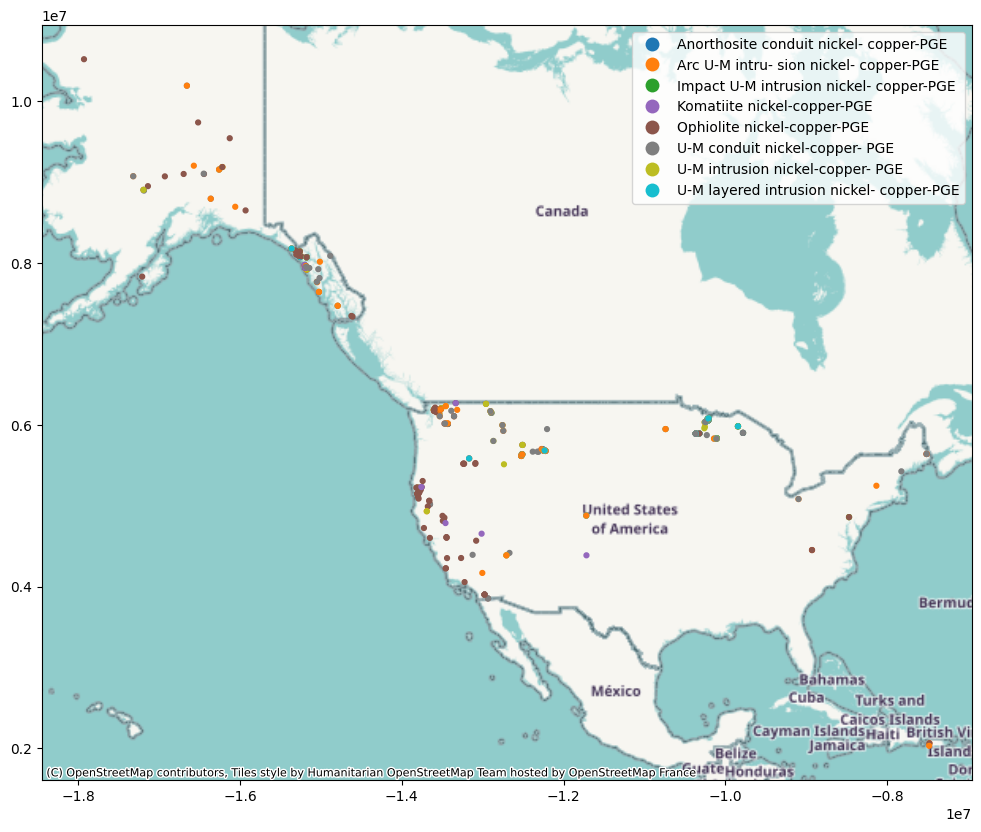

In [40]:
#visualize
hypersite_df_filtered['loc_wkt'] = hypersite_df_filtered['loc_wkt.value'].progress_apply(safe_wkt_load)
sample_gdf = gpd.GeoDataFrame(hypersite_df_filtered, geometry='loc_wkt', crs='epsg:4326')
# WGS84 (EPSG:4326) to Web Mercator (EPSG:3857).
sample_gdf = sample_gdf.to_crs(epsg=3857)
fig, ax = plt.subplots(figsize=(12, 12))
sample_gdf.plot(ax=ax, markersize=12, column='dtnorm_label.value', categorical=True, legend=True)
#ax.set_axis_off()
ctx.add_basemap(ax)
plt.show()

## Grade-Tonnage models

In [41]:
query = ''' SELECT ?ms ?ms_name ?mi ?mi_cat ?ore_val ?ore_unit_lbl ?grade_val ?grade_unit_lbl ?cutoff_grade ?dt_conf ?dt_s ?dtnorm ?dtnorm_label ?country ?loc_wkt
            WHERE {
                ?ms :mineral_inventory ?mi .
                OPTIONAL { ?ms rdfs:label|:name ?ms_name . }

                ?ms :deposit_type_candidate ?dpc .
                  
                ?dpc :confidence ?dt_conf .
                ?dpc :source ?dt_s .
                ?dpc :normalized_uri ?dtnorm .
                ?dtnorm rdfs:label ?dtnorm_label .
                
                OPTIONAL {
                      ?ms :location_info [ :country ?country ] .
                      ?ms :location_info [ :location ?loc_wkt ] .
                      FILTER(datatype(?loc_wkt) = geo:wktLiteral)
                }
                
                ?mi :category ?mi_cat .
                ?mi :commodity [ :name "Nickel"@en ] .
                
                OPTIONAL { ?mi :ore [ :ore_value ?ore_val;
                                      :ore_unit  ?ore_unit] .
                                      ?ore_unit rdfs:label ?ore_unit_lbl . }
                OPTIONAL { ?mi :grade [ :grade_value ?grade_val;
                                      :grade_unit  ?grade_unit] .
                                      ?grade_unit rdfs:label ?grade_unit_lbl . }
                OPTIONAL { ?mi :cutoff_grade [ :grade_value ?cutoff_grade ] . }
            } '''
query_resp_df = run_minmod_query(query, values=True)

In [42]:
mineral_data_df = pd.DataFrame([
    {
        'ms': row['ms.value'], # This is not yet the name, it's the suffix of the uri
        'ms_name': row['ms_name.value'] if len(row['ms_name.value']) > 0 else row['ms.value'].split('/')[-1],
        'mi': row['mi.value'].split('/')[-1],
        'mi_cat': row['mi_cat.value'].lower().split('/')[-1],
        'ore_val': float(row['ore_val.value']),
        'ore_unit': row['ore_unit_lbl.value'],
        'grade_val': float(row['grade_val.value']),
        'grade_unit': row['grade_unit_lbl.value'],
        'cutoff_grade': float(row['cutoff_grade.value']),
        'cutoff_grade_unit': row['cutoff_grade.value'],
        'deposit_type_qnode': row['dtnorm.value'],
        'deposit_type': row['dtnorm_label.value'],
        'dep_type_score': float(row['dt_conf.value']),
        'country': row['country.value'],
        'loc_wkt': row['loc_wkt.value']
    }
    for index, row in query_resp_df.iterrows()
])
mineral_data_df

,ms,ms_name,mi,mi_cat,ore_val,ore_unit,grade_val,grade_unit,cutoff_grade,cutoff_grade_unit,deposit_type_qnode,deposit_type,dep_type_score,country,loc_wkt
0,https://minmod.isi.edu/resource/httpsw3idorgus...,NI 43-101 Technical Report for the Hitura Proj...,httpsw3idorgusgsz45306924j6vp5m91f1f950227725c...,probable,350000.0,tonnes,0.62,percent,NaN,NaN,https://minmod.isi.edu/resource/Q484,Ophiolite nickel-copper-PGE,0.071153,Finland,POINT(25.05 63.85)
1,https://minmod.isi.edu/resource/httpsw3idorgus...,NI 43-101 Technical Report for the Hitura Proj...,httpsw3idorgusgsz45306924j6vp5m91f1f950227725c...,probable,350000.0,tonnes,0.62,percent,NaN,NaN,https://minmod.isi.edu/resource/Q488,Anorthosite conduit nickel- copper-PGE,0.054055,Finland,POINT(25.05 63.85)
2,https://minmod.isi.edu/resource/httpsw3idorgus...,NI 43-101 Technical Report for the Hitura Proj...,httpsw3idorgusgsz45306924j6vp5m91f1f950227725c...,probable,350000.0,tonnes,0.62,percent,NaN,NaN,https://minmod.isi.edu/resource/Q319,Laterite nickel,0.055366,Finland,POINT(25.05 63.85)
3,https://minmod.isi.edu/resource/httpsw3idorgus...,NI 43-101 Technical Report for the Hitura Proj...,httpsw3idorgusgsz45306924j6vp5m91f1f950227725c...,probable,350000.0,tonnes,0.62,percent,NaN,NaN,https://minmod.isi.edu/resource/Q478,U-M layered intrusion nickel- copper-PGE,0.088073,Finland,POINT(25.05 63.85)
4,https://minmod.isi.edu/resource/httpsw3idorgus...,NI 43-101 Technical Report for the Hitura Proj...,httpsw3idorgusgsz45306924j6vp5m91f1f950227725c...,probable,350000.0,tonnes,0.62,percent,NaN,NaN,https://minmod.isi.edu/resource/Q481,U-M intrusion nickel-copper- PGE,0.090854,Finland,POINT(25.05 63.85)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14333,https://minmod.isi.edu/resource/httpsw3idorgus...,NI 43-101 Technical Report for the Lantinen Ko...,httpsw3idorgusgsz45306922p29bjhv16651f5a2eff1c...,indicated,10.4,million tonnes,0.10,percent,NaN,NaN,https://minmod.isi.edu/resource/Q481,U-M intrusion nickel-copper- PGE,0.059178,Finland,POINT(28.17472 65.94611)
14334,https://minmod.isi.edu/resource/httpsw3idorgus...,NI 43-101 Technical Report for the Lantinen Ko...,httpsw3idorgusgsz45306922p29bjhv16651f5a2eff1c...,indicated,10.4,million tonnes,0.10,percent,NaN,NaN,https://minmod.isi.edu/resource/Q304,Fluvial placer PGE,0.064721,Finland,POINT(28.17472 65.94611)
14335,https://minmod.isi.edu/resource/httpsw3idorgus...,NI 43-101 Technical Report for the Lantinen Ko...,httpsw3idorgusgsz45306922p29bjhv16651f5a2eff1c...,indicated,10.4,million tonnes,0.10,percent,NaN,NaN,https://minmod.isi.edu/resource/Q479,U-M layered intrusion PGE,0.136808,Finland,POINT(28.17472 65.94611)
14336,https://minmod.isi.edu/resource/httpsw3idorgus...,NI 43-101 Technical Report for the Lantinen Ko...,httpsw3idorgusgsz45306922p29bjhv16651f5a2eff1c...,indicated,10.4,million tonnes,0.10,percent,NaN,NaN,https://minmod.isi.edu/resource/Q478,U-M layered intrusion nickel- copper-PGE,0.080314,Finland,POINT(28.17472 65.94611)


In [43]:
#filtered_us = mineral_data_df
filtered_us = mineral_data_df[mineral_data_df['country'].isin(["USA", "United States", "United States of America"])]
#filtered_nickel_us = filtered_us
filtered_nickel_us = filtered_us[filtered_us['deposit_type_qnode'].isin(valid_deposit_Qs)]
mineral_data_df = filtered_nickel_us.copy()
len(mineral_data_df)

12259

In [44]:
# keep only highest confidence per mineral site uri
# group by 'ms' & find the index of the highest 'dep_type_score' in each group
idx = mineral_data_df.groupby('ms')['dep_type_score'].idxmax()
#  keep only the rows with the highest 'dep_type_score' for each 'ms'
filtered_mineral_data_df = mineral_data_df.loc[idx]
mineral_data_df = filtered_mineral_data_df

In [45]:
print(f"taking the {len(mineral_data_df[mineral_data_df['dep_type_score'] == 1.0])} results with 1.0 confidence from all {len(mineral_data_df)} unique sites")
mineral_data_df = mineral_data_df[mineral_data_df['dep_type_score'] == 1.0]

taking the 20 results with 1.0 confidence from all 22 unique sites


In [46]:
mineral_data_df['mi_cat'].value_counts()

mi_cat
inferred     16
indicated     2
measured      2
Name: count, dtype: int64

In [47]:
filtered_mineral_data_df = mineral_data_df[mineral_data_df['mi_cat'].isin(['inferred', 'indicated', 'measured'])]
filtered_mineral_data_df = filtered_mineral_data_df.drop_duplicates(subset=['ms', 'mi_cat'])
len(filtered_mineral_data_df)

20

In [48]:
filtered_mineral_data_df['ore_unit'].value_counts()

ore_unit
million tonnes    17
tonnes             3
Name: count, dtype: int64

In [49]:
# todo: assumes "million tonnes" OR "tonnes" for ore_unit & percent for grade_unit (the case as of today)
# normalize: convert rows with tonnes to million tonnes 
filtered_mineral_data_df['norm_ore_val'] = filtered_mineral_data_df.progress_apply(lambda row:
                             row['ore_val'] / 1e6 if row['ore_unit'] == 'tonnes' else row['ore_val'], axis=1)
                             #row['ore_val'] * 1e6 if row['ore_unit'] == 'million tonnes' else row['ore_val'], axis=1)

100%|██████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 18745.49it/s]


In [50]:
# pivot the table: new df with each 'mi_cat' as a prefix
#pivot_df = filtered_mineral_data_df.pivot_table(index=['ms', 'ms_name'], columns='mi_cat', 
pivot_df = filtered_mineral_data_df.pivot_table(index=['ms', 'ms_name', 'deposit_type', 'dep_type_score', 'loc_wkt'], columns='mi_cat', 
                          values=['norm_ore_val', 'grade_val', 'cutoff_grade'],
                          aggfunc='first')
# flatten the MultiIndex in columns
pivot_df.columns = ['_'.join(col).strip() for col in pivot_df.columns.values]
# reset index to turn 'ms' back into a column
pivot_df.reset_index(inplace=True)
pivot_df.fillna('', inplace=True)
pivot_df

,ms,ms_name,deposit_type,dep_type_score,loc_wkt,cutoff_grade_indicated,cutoff_grade_inferred,grade_val_indicated,grade_val_inferred,grade_val_measured,norm_ore_val_indicated,norm_ore_val_inferred,norm_ore_val_measured
0,https://minmod.isi.edu/resource/httpsw3idorgus...,NI 43-101 Technical Report on the Maturi Birch...,U-M layered intrusion nickel- copper-PGE,1.0,"MULTIPOINT(-91.708333 47.696944,-91.791667 47....",,0.6,,0.14,,,542.0,
1,https://minmod.isi.edu/resource/httpsw3idorgus...,Technical Report on the Mineral Resource Estim...,U-M layered intrusion nickel- copper-PGE,1.0,POINT(-91.759305555556 47.799861111111),,23.0,,0.25,,,41.1,
2,https://minmod.isi.edu/resource/httpsw3idorgus...,Preliminary Economic Assessment (PEA) of the T...,U-M conduit nickel-copper- PGE,1.0,POINT(-93.10603 46.697),0.83,,1.83,,,3.639,,
3,https://minmod.isi.edu/resource/httpsw3idorgus...,NI 43-101 Technical Report on the Maturi Birch...,U-M layered intrusion nickel- copper-PGE,1.0,"MULTIPOINT(-91.70833 47.78333,-91.79167 47.696...",0.4,,0.22,,,607.0,,
4,https://minmod.isi.edu/resource/httpsw3idorgus...,Technical Report on the Preliminary Assessment...,U-M layered intrusion nickel- copper-PGE,1.0,POINT(-91.8 47.733333),,25.0,,0.24,,,0.10043,
5,https://minmod.isi.edu/resource/httpsw3idorgus...,First Independent Technical Report on the Tama...,U-M conduit nickel-copper- PGE,1.0,POINT(-93.1 46.683),,0.9,,5.25,,,3.119,
6,https://minmod.isi.edu/resource/site__birch-la...,Birch Lake,U-M layered intrusion nickel- copper-PGE,1.0,POINT (-91.8 47.75),,,,0.15,,,217.0,
7,https://minmod.isi.edu/resource/site__bohemia-...,Bohemia Basin (Basin-Takanis-Flapjack),U-M intrusion nickel-copper- PGE,1.0,POINT (-136.43427 57.98471),,,,0.42,,,20.0,
8,https://minmod.isi.edu/resource/site__eagle-ea...,Eagle-Eagle East (USA),U-M conduit nickel-copper- PGE,1.0,POINT (-87.88151 46.74852),,,,,2.6,,,1.868
9,https://minmod.isi.edu/resource/site__maturi-i...,Maturi (incl. Nokomis),U-M layered intrusion nickel- copper-PGE,1.0,POINT (-91.8 47.8),,,,0.16,,,534.1,


In [51]:
def get_total_grade_tonnage(flat_mi):
    ''' assumes tonnage units in tonnes 
        input: flat_mi = flat mineral inventory record (pandas seriers record)
        output: total_tonnage, total_grade '''
    
    # init in case of None(s)
    contained_measured, contained_indicated, contained_inferred = 0, 0, 0
    
    tonnage_measured  = float(flat_mi.norm_ore_val_measured)  if flat_mi.norm_ore_val_measured  != '' else 0
    tonnage_indicated = float(flat_mi.norm_ore_val_indicated) if flat_mi.norm_ore_val_indicated != '' else 0
    tonnage_inferred  = float(flat_mi.norm_ore_val_inferred)  if flat_mi.norm_ore_val_inferred  != '' else 0

    total_tonnage = tonnage_measured + tonnage_indicated + tonnage_inferred

    if total_tonnage == 0:
        return None, None

    '''
    (1) contained_nickel_of_measured  = measured_tonnage  * grade (commodity)
    (2) contained_nickel_of_indicated = indicated_tonnage * grade (commodity)
    (3) contained_nickel_of_inferred  = inferred_tonnage  * grade (commodity)
    (4) total_tonnage [X axis]        = measured_tonnage + indicated_tonnage + inferred_tonnage
    (5) total_contained_metal         = contained_nickel_of_measured + contained_nickel_of_indicated + contained_nickel_of_inferred 
    (6) total_grade   [Y axis]        = (5)/(4) 
    '''
    
    if flat_mi.grade_val_measured != '':
        contained_measured  = tonnage_measured  * float(flat_mi.grade_val_measured)
    if flat_mi.grade_val_indicated != '':
        contained_indicated = tonnage_indicated * float(flat_mi.grade_val_indicated)
    if flat_mi.grade_val_inferred != '':
        contained_inferred  = tonnage_inferred  * float(flat_mi.grade_val_inferred)
    
    total_contained_metal = contained_measured + contained_indicated + contained_inferred

    if total_contained_metal == 0:
        return None, None

    total_grade = float(total_contained_metal) / float(total_tonnage)

    return total_tonnage, total_grade

In [52]:
# apply the function and get the results as a list of tuples
gr_ton_results = pivot_df.progress_apply(lambda x: get_total_grade_tonnage(x), axis=1)
# split the results into two separate Series and assign them to new columns
pivot_df['total_tonnage'], pivot_df['total_grade'] = zip(*gr_ton_results)

100%|██████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 16448.25it/s]


In [53]:
# uncomment to export to csv: 
#pivot_df.to_csv('nickel_gradetonnage_with_deposits_v2.csv', index=False)

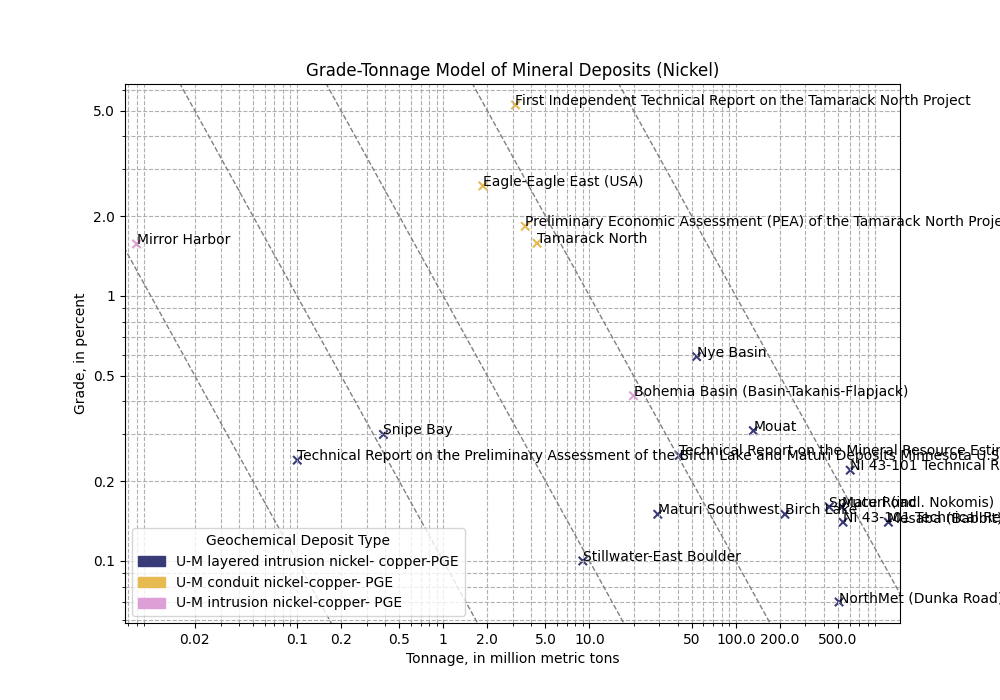

In [54]:
%matplotlib ipympl
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import webbrowser

# Your existing DataFrame and data extraction
tonnages = pivot_df['total_tonnage'].values
grades = pivot_df['total_grade'].values
names = pivot_df['ms_name'].values
dtnorm_labels = pivot_df['deposit_type'].values
urls = pivot_df['ms'].values  # URLs corresponding to each point

# Define color for each unique category in 'dtnorm_label_value'
unique_labels = pivot_df['deposit_type'].unique()
colors = plt.cm.tab20b(np.linspace(0, 1, len(unique_labels)))  # Using 'viridis' colormap
color_map = dict(zip(unique_labels, colors))

# Create list of colors for each point
point_colors = [color_map[label] for label in dtnorm_labels]

plt.figure(figsize=(10, 7))
scatter = plt.scatter(tonnages, grades, marker='x', c=point_colors, picker=5)  # Enable picking with a tolerance of 5 points

# Logarithmic scale
plt.xscale('log')
plt.yscale('log')

# Custom ticks for the x-axis and y-axis
x_ticks = [0.02, 0.1, 0.2, 0.5, 1, 2.0, 5.0, 10.0, 50, 100.0, 200.00, 500.00]
y_ticks = [0.02, 0.1, 0.2, 0.5, 1, 2.0, 5.0]
plt.xticks(x_ticks, labels=[str(x) for x in x_ticks])
plt.yticks(y_ticks, labels=[str(y) for y in y_ticks])

# Diagonal lines and annotations for constant tonnage-grade products
i, line_x_p, line_y_p, prev_x_p, prev_y_p = 0, 0, 0, 0, 0
product_values = [1e-2, 1e-1, 1, 10, 1e2]  # Constant tonnage-grade products to represent
for i, product in enumerate(product_values):
    # Calculate the grade at the plot's min and max tonnages for the constant product
    min_tonnage, max_tonnage = plt.xlim()
    min_grade = product / min_tonnage
    max_grade = product / max_tonnage
    # Plot the diagonal line
    plt.plot([min_tonnage, max_tonnage], [min_grade, max_grade], 'k--', lw=1, color='gray')
    # Add annotation at a specific point / todo: uncomment
    # line_x_p = np.sqrt(min_tonnage * max_tonnage)
    # line_y_p = product / np.sqrt(min_tonnage * max_tonnage)
    # if product == 10e-2:
    #     line_x_p, line_y_p = 0.1, 1
    # elif product == 10e-1:
    #     line_x_p, line_y_p = 0.5, 2
    # elif product == 10:
    #     line_x_p, line_y_p = 0.2, 50
    # line_x_p *= 1.18
    # plt.text(line_x_p, line_y_p, 
    #          f'{product*10e3} metric tons', rotation=-33, verticalalignment='bottom', horizontalalignment='right', color='gray')

# Labels and title
plt.xlabel('Tonnage, in million metric tons')
plt.ylabel('Grade, in percent')
plt.title('Grade-Tonnage Model of Mineral Deposits (Nickel)')

plt.grid(True, which="both", ls="--")

# Annotations
for i, txt in enumerate(names):
    plt.annotate(txt, (tonnages[i], grades[i]))

# Legend
legend_handles = [mpatches.Patch(color=color_map[label], label=label) for label in unique_labels]
plt.legend(handles=legend_handles, title="Geochemical Deposit Type", loc='lower left')

# Function to open URL on click
def on_pick(event):
    ind = event.ind[0]  # Index of the picked scatter point
    url = urls[ind]
    webbrowser.open(url)  # Open the URL

# Set x-axis bounds
plt.xlim(pivot_df['total_tonnage'].min()/1.2, pivot_df['total_tonnage'].max()*1.2)
# Set y-axis bounds
plt.ylim(pivot_df['total_grade'].min()/1.2, pivot_df['total_grade'].max()*1.2)

# Connect the pick event to the on_pick function
plt.gcf().canvas.mpl_connect('pick_event', on_pick)

plt.show()